In [1]:
from src.generator import data_generator, clip_generator, label_generator
from src.util import characters, id_from_char, char_from_id
from src.models import create_model

from pymongo import MongoClient
from tensorflow import keras

import numpy as np
import pickle

In [2]:
for character in characters:
    print(character)

CAPTAIN_FALCON
DONKEY_KONG
FOX
GAME_AND_WATCH
KIRBY
BOWSER
LINK
LUIGI
MARIO
MARTH
MEWTWO
NESS
PEACH
PIKACHU
ICE_CLIMBERS
JIGGLYPUFF
SAMUS
YOSHI
ZELDA
SHEIK
FALCO
YOUNG_LINK
DR_MARIO
ROY
PICHU
GANONDORF


# The Model

Source code for model creation is in src/models.py

In [3]:
# # to make a new model
# model = create_model()

In [4]:
# to load the saved model
model = keras.models.load_model('models/cnn_model')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 150)         58650     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 150)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 150)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 80)          360080    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 80)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 80)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 80)          1

# Testing

In [24]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]
collection.estimated_document_count()

916647

In [25]:
batch_size = 100
skip = None    # no skip because first 100k clips are test data
step = 23       # to ensure that consecutive clips aren't from the same player and game
repeat = True  # keep this as True, allows generator to loop through database infinitley
limit = 100000 # only look at test data (first 100k clips)

num_batches = 100

In [26]:
data_test = data_generator(clip_collection=collection,
                           batch_size = batch_size,
                           skip=skip,
                           step=step,
                           repeat=repeat,
                           limit=limit)

X_test = clip_generator(clip_collection=collection,
                        batch_size = batch_size,
                        skip=skip,
                        step=step,
                        repeat=repeat,
                        limit=limit)

Y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit, 
                         onehot=True)

y_test = label_generator(clip_collection=collection,
                         batch_size = batch_size,
                         skip=skip,
                         step=step,
                         repeat=repeat,
                         limit=limit,
                         onehot=False)

In [27]:
score = model.evaluate(data_test, steps=num_batches, verbose=1)

print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 categorical accuracy: {round(score[2]*100)}%') 

100/100 [==============================] - 74s 744ms/step - loss: 0.0327 - accuracy: 0.9450 - top 8 accuracy: 0.9839

Test score: 0.033
Test accuracy: 94%
Test test top 8 categorical accuracy: 98%


# Confusion Matrix

In [28]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [29]:
def get_conf_matrix(labels_as_id, predictions_as_id):
    conf_matrix = np.zeros((27,27))
    for i_real, i_pred in zip(labels_as_id, predictions_as_id):
        conf_matrix[i_real, i_pred] += 1
    return conf_matrix

In [30]:
recalls = {k:0 for k in range(1,27)}
precisions = {k:0 for k in range(1,27)}

pred = np.argmax(model.predict(X_test, steps=num_batches, verbose=1), axis = 1)

if repeat:
    labels = np.concatenate([next(y_test) for _ in range(num_batches)])
else:
    labels = np.concatenate([label for label in y_test])

conf_matrix = get_conf_matrix(labels, pred)
conf_df = pd.DataFrame(conf_matrix[1:,1:], index=characters, columns=characters)

100/100 [==============================] - 73s 733ms/step


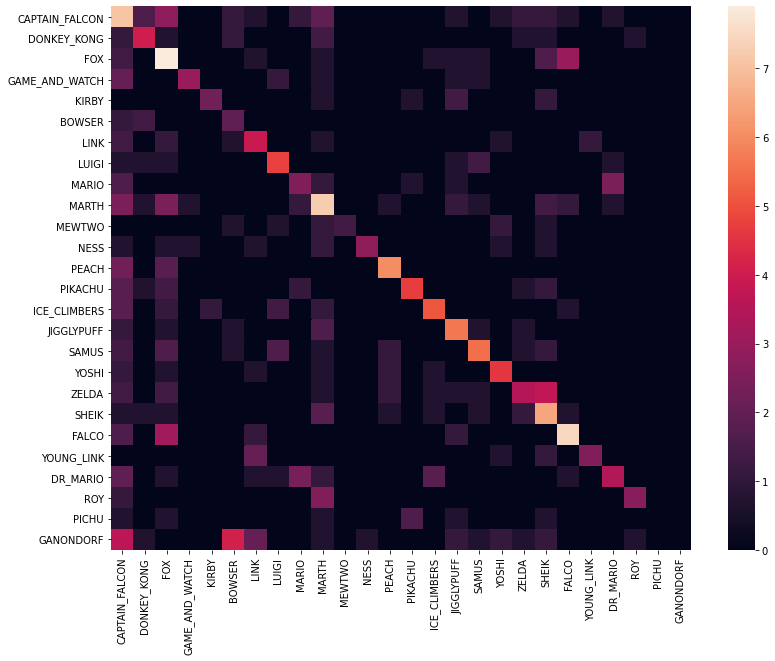

In [31]:
# sn.heatmap(conf_df, annot=False, mask=conf_df <= 0, cmap='viridis')
fig, ax = plt.subplots(figsize=(13,10))
sn.heatmap(np.log(1 + conf_df), annot=False, ax=ax, square=False)
fig.savefig('images/confusion_matrix.png')

# Training

In [13]:
database_name = 'slippi'
collection_name = 'melee_clips_30s'

# Connect to the hosted MongoDB instance
client = MongoClient('localhost', 27017)
db = client[database_name]
collection = db[collection_name]

In [14]:
# skip first 100k clips and save them as test data
data = data_generator(collection, batch_size=100, skip=100000, step=101, repeat=True)

In [15]:
model.fit(data, epochs=10, steps_per_epoch=500, verbose=1)

score = model.evaluate(data, steps=50, verbose=0)
print('\nTest score:', round(score[0], 3))
print(f'Test accuracy: {round(score[1]*100)}%')
print(f'Test test top 8 accuracy: {round(score[2]*100)}%')

Epoch 1/10
500/500 [==============================] - 1410s 3s/step - loss: 0.0445 - accuracy: 0.9260 - top 8 accuracy: 0.9787
Epoch 2/10
500/500 [==============================] - 1409s 3s/step - loss: 0.0435 - accuracy: 0.9271 - top 8 accuracy: 0.9794
Epoch 3/10
500/500 [==============================] - 1410s 3s/step - loss: 0.0446 - accuracy: 0.9268 - top 8 accuracy: 0.9787
Epoch 4/10
500/500 [==============================] - 1411s 3s/step - loss: 0.0443 - accuracy: 0.9266 - top 8 accuracy: 0.9791
Epoch 5/10
500/500 [==============================] - 1412s 3s/step - loss: 0.0448 - accuracy: 0.9259 - top 8 accuracy: 0.9792
Epoch 6/10
500/500 [==============================] - 1416s 3s/step - loss: 0.0450 - accuracy: 0.9262 - top 8 accuracy: 0.9788
Epoch 7/10
500/500 [==============================] - 1409s 3s/step - loss: 0.0447 - accuracy: 0.9274 - top 8 accuracy: 0.9789
Epoch 8/10
500/500 [==============================] - 1413s 3s/step - loss: 0.0440 - accuracy: 0.9269 - top 8 a

In [32]:
model.save('models/cnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
